# Lab 07: Credit Card Fraud Detection

---
author: Alex Soja
date: October 25, 2024
embed-resources: true
---

## Introduction

In this report we aim to create an automated fraud detector. As soon as a credit card transaction is made, given the information available at the time of the transaction (location, amount, etc), our model theoretically should  immediately identify the transaction as fraudulent or genuine. In other words our goal is to find a model that appropriately balances false positives and false negatives.

## Methods

In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    fbeta_score,
    make_scorer,
    precision_score,
    recall_score,
)
from sklearn.model_selection import (
    GridSearchCV,
    train_test_split,
)
from pprint import pprint
import seaborn as sns

### Data

In [3]:
# load data
fraud = pd.read_parquet("https://cs307.org/lab-07/data/fraud.parquet")

#### Data Description
The data for this lab originally comes from Kaggle. Citations for the data can be found on Kaggle.

Kaggle: Credit Card Fraud Detection
A brief description of the target variable is given.

This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

Similarly, a brief description of the feature variables is given.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are ‘Time’ and ‘Amount’. Feature ‘Time’ contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature ‘Amount’ is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature ‘Class’ is the response variable and it takes value 1 in case of fraud and 0 otherwise.

We are providing a modified version of this data for this lab.

Modifications include:

Removed the Time variable as it is misleading.
Reduced the number of samples, while maintaining the number of fraudulent transactions.
The class imbalance is reduced, but the target is still highly imbalanced.
Withheld some data that will be considered the production data.
Renamed the target variable from Class to Fraud.
Renamed the PCA transformed variables.


#### Data Dictionary

Each observation in the train, test, and (hidden) production data contains information about a particular credit card transaction.

#### Response

**`Fraud`**

- `[int64]` status of the transaction. 1 indicates a fraudulent transaction and 0 indicates not fraud, a genuine transaction.

#### Features

**`Amount`**

- `[float64]` amount (in dollars) of the transaction.

**`PC01 - PC28`**

- `[float64]` the 28 principal components that encode information such as location and type of purchase while preserving customer privacy.


In [25]:
# summary statistics
from sklearn.model_selection import train_test_split
fraud_train, fraud_test = train_test_split(
    fraud,
    test_size=0.20,
    random_state=42,
    stratify=fraud["Fraud"],
)

fraudy = fraud_train[fraud_train['Fraud'] == 1]
non = fraud_train[fraud_train['Fraud'] == 0]
total = len(fraudy)+len(non)

print("Fraud Count:",len(fraudy))
print("Not Fraud Count:",len(non))
print("Proportion of Fraud: ", len(fraudy)/total)
print("Proportion of Not Fraud: ",len(non)/total)

#non["Amount"].max()

#len(fraud_train.columns)


Fraud Count: 315
Not Fraud Count: 53961
Proportion of Fraud:  0.005803670130444395
Proportion of Not Fraud:  0.9941963298695556


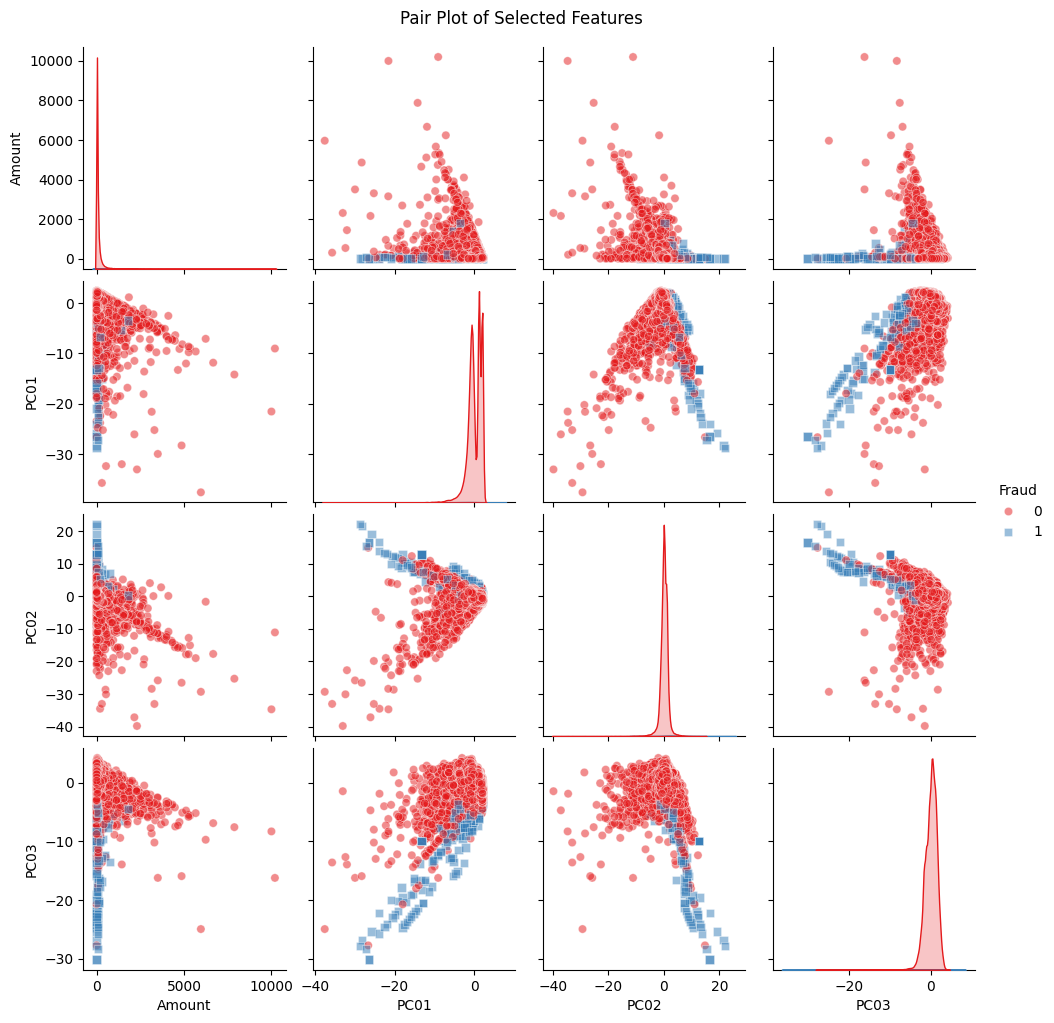

In [ ]:
# | echo: false
# visualizations
selected_features = ["Amount", "PC01", "PC02", "PC03", "Fraud"]
sns.pairplot(fraud_train[selected_features], hue="Fraud", palette="Set1", markers=["o", "s"], plot_kws={'alpha': 0.5})
plt.suptitle("Pair Plot of Selected Features", y=1.02)
plt.show()


In both our summary statistics and pair-plot visualization we can see that there is very minimal data that is indeed fraud. Although our graph only shows 3 principal components, comparing it to the numbers we saw before we can assume tht a similar relationship is shown with the other components. This limited fraud data may cause us some issues in our modeling.

### Models

In [20]:
# process data for ML
# create X and y for train
X_train = fraud_train.drop("Fraud", axis=1)
y_train = fraud_train["Fraud"]

# create X and y for test
X_test = fraud_test.drop("Fraud", axis=1)
y_test = fraud_test["Fraud"]

To develop a model, we tuned a Random Forest Classifier model. For this we consider various values of the available tuning parameters. (See the `param_grid` below.)

Tuning was performed via cross-validation using a grid-search of the specified parameters. Models were compared using scoring.

In [26]:

def print_metric_scores(grid, metric):
    cv_results = grid.cv_results_
    best_index = grid.best_index_
    mean_score = cv_results[f"mean_test_{metric}"][best_index]
    std_score = cv_results[f"std_test_{metric}"][best_index]
    print(f"CV {metric} (mean ± std): {mean_score:.3f} ± {std_score:.3f}")


rf = RandomForestClassifier(random_state=42)

# weights for helping with imbalance
weights_list = [
    #{0: 1, 1: 2},
    #{0: 1, 1: 3},
    "balanced",
]

# define scoring metrics
scoring = {
    "accuracy": make_scorer(accuracy_score),
    "recall": make_scorer(recall_score),
    "precision": make_scorer(precision_score, zero_division=0),
    "f1": make_scorer(fbeta_score, beta=1),
}

# Define the parameter grid for the grid search
rf_param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [3, 5],
    "class_weight": weights_list,
}

# Create a GridSearchCV object
mod = GridSearchCV(
    rf,
    rf_param_grid,
    cv=5,
    scoring=scoring,
    refit="f1",
)

# Fit the grid search object on the training data
mod.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced'], 'max_depth': [3, 5],
                         'n_estimators': [50, 100]},
             refit='f1',
             scoring={'accuracy': make_scorer(accuracy_score, response_method='predict'),
                      'f1': make_scorer(fbeta_score, response_method='predict', beta=1),
                      'precision': make_scorer(precision_score, response_method='predict', zero_division=0),
                      'recall': make_scorer(recall_score, response_method='predict')})

## Results

In [29]:
# | echo: false
print("")
print(f"Of the model parameters considered the best were the following;")
pprint(mod.best_params_)
print("")
print(f"Our Cross-Validation Scores:")
print_metric_scores(mod, "accuracy")
print_metric_scores(mod, "precision")
print_metric_scores(mod, "recall")
print_metric_scores(mod, "f1")

y_pred = mod.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred)
test_recall = recall_score(y_test, y_pred)
test_f1 = fbeta_score(y_test, y_pred, beta=1)

print("")
print(f"Our Test Scores:")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test F1 Score: {test_f1}")


Of the model parameters considered the best were the following;
{'class_weight': 'balanced', 'max_depth': 5, 'n_estimators': 100}

Our Cross-Validation Scores:
CV accuracy (mean ± std): 0.997 ± 0.001
CV precision (mean ± std): 0.748 ± 0.063
CV recall (mean ± std): 0.860 ± 0.039
CV f1 (mean ± std): 0.798 ± 0.037

Our Test Scores:
Test Accuracy: 0.9976416832485814
Test Precision: 0.7701149425287356
Test Recall: 0.8481012658227848
Test F1 Score: 0.8072289156626506


In [30]:
# | echo: false
# report model metrics
from joblib import dump
dump(mod, "credit-fraud.joblib")

['credit-fraud.joblib']

## Discussion

Although our scores weren't perfect they were still relatively high. Our Recall was higher than our Precision due to it being more critical when false negatives are costly.

As stated earlier there weren't many data points that fell under the fraud category. If we could increase the amount of data specifically those marked as fraud it should hopefully increase our accuracy and other cv scores. The only issue is our model took a good amount of time to run and since we would want to instantly predict these fraud cases upon transactions it could be an issue of speed.

### Conclusion

Despite the mentioned flaws, our test scores trials did very well and we would recommend similar models in the future. To put it into practice however I would recommend increasing the test scores and cv scores however possible before doing so. 